# Dogs Vs Cats Classification with Basic CNN Neural Network Using Tensorflow and Keras

Based on Part 1 of https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html with several additions:
- callback: checkpoint and early stopping
- saving model to model file, or to architecture (in json) + weights separately
- loading model from model file, or from architecture (in json) + weights separately
- use model to make prediction/evaluation on a single image
- use model to make prediction/evaluation on a batch of test image (different from validation, this is as if to simulate real world testing on data that have not been tested or seen in training stage

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

## Define constants

In [3]:
# dimensions of our images
img_width, img_height = 150, 150

PATH = 'data/dogscats_small/'
train_data_dir = f'{PATH}train/'
validation_data_dir = f'{PATH}validation/'
test_data_dir = f'{PATH}test/'

epochs = 30
batch_size = 16

In [4]:
# value stored in /users/<user>/keras/.keras.json file
# "channels_last" for tensorflow

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Helper functions

In [5]:
# ensure the child directories are non-empty and contain jpg files
def rand_img_from_child_dirs(dir_path):
    
    dirs =  [directory for directory in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,directory)) 
             and not directory.startswith('.')]
    random_dir = np.random.choice(dirs)
    random_dir_path = os.path.join(dir_path,random_dir)
    files =  [file for file in os.listdir(random_dir_path) if file.endswith('.jpg')]
    random_img = np.random.choice(files)

    return os.path.join(random_dir_path,random_img)

In [6]:
def plot_training_history(log):
    acc = log.history['acc']
    val_acc = log.history['val_acc']
    loss = log.history['loss']
    val_loss = log.history['val_loss']

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, 'b', label='Training acc')
    plt.plot(epoch_range, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, 'b', label='Training loss')
    plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Build neural network model

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
__________

## Setup training and validation data

In [9]:
# rescaling + data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# only rescaling for validation data
# no augmentation because we want the classification result for the actual file itself
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Image Augmentation

In [11]:
# running augmentation seem to cause problem during training
# maybe in the datagen.flow part
gen_augmentation_samples = False  

if gen_augmentation_samples:
    os.makedirs('tmp/img_augmentations', exist_ok=True)
    
    rand_img_path = rand_img_from_child_dirs(validation_data_dir)
    rand_img_augm = image.load_img(rand_img_path, target_size=(img_width, img_height))
    
    x = img_to_array(rand_img_augm)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    # x = np.expand_dims(x, axis=0)
    
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `tmp/img_augmentations/` directory
    i = 0
    for batch in train_datagen.flow(x, batch_size=1,
                              save_to_dir='tmp/img_augmentations', save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 10:
            break  # otherwise the generator would loop indefinitely

## Setup callbacks - checkpoint and early stopping

In [12]:
# cannot use F-string format
checkpoint_file_path = PATH + "models/baseline_weights_{epoch:02d}_{val_loss:.2f}_{val_acc:.2f}.h5" 

checkpoint = ModelCheckpoint(checkpoint_file_path, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')

early_stop = False # optional, prefer not to use for this example

if early_stop:
    callbacks_list = [checkpoint, early_stopping]
else:
    callbacks_list = [checkpoint]

## Train

In [13]:
%%time
training_log = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    workers=4,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    callbacks=callbacks_list)

Epoch 1/30
123/125 [============================>.] - ETA: 0s - loss: 0.7063 - acc: 0.5584
Epoch 00001: val_acc improved from -inf to 0.67625, saving model to data/dogscats_small/models/baseline_weights_01_0.66_0.68.h5
125/125 [==============================] - 13s 105ms/step - loss: 0.7060 - acc: 0.5585 - val_loss: 0.6633 - val_acc: 0.6763
Epoch 2/30
124/125 [============================>.] - ETA: 0s - loss: 0.6657 - acc: 0.6351
Epoch 00002: val_acc did not improve from 0.67625
125/125 [==============================] - 11s 87ms/step - loss: 0.6665 - acc: 0.6345 - val_loss: 0.6398 - val_acc: 0.6212
Epoch 3/30
124/125 [============================>.] - ETA: 0s - loss: 0.6132 - acc: 0.6689
Epoch 00003: val_acc improved from 0.67625 to 0.69375, saving model to data/dogscats_small/models/baseline_weights_03_0.58_0.69.h5
125/125 [==============================] - 11s 87ms/step - loss: 0.6122 - acc: 0.6695 - val_loss: 0.5753 - val_acc: 0.6937
Epoch 4/30
123/125 [============================

Epoch 30/30
124/125 [============================>.] - ETA: 0s - loss: 0.3800 - acc: 0.8468
Epoch 00030: val_acc did not improve from 0.78500
125/125 [==============================] - 11s 88ms/step - loss: 0.3809 - acc: 0.8465 - val_loss: 0.5224 - val_acc: 0.7688
CPU times: user 20min 3s, sys: 28.6 s, total: 20min 31s
Wall time: 5min 30s


### Retrieve each training epoch result

In [14]:
print(training_log.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


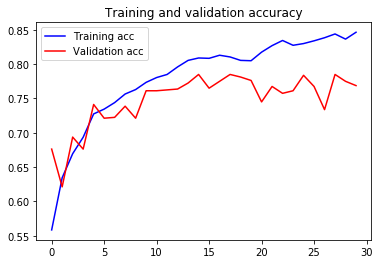

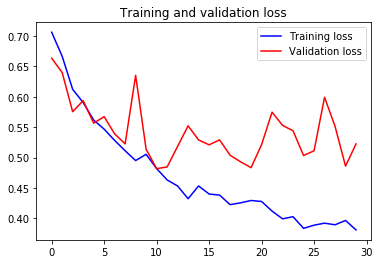

In [15]:
plot_training_history(training_log)

## Save model

### Save as full model

In [16]:
model.save(f'{PATH}/models/baseline_model.h5')

### Save as architecture definition (json) + weights value

In [17]:
model_json = model.to_json()

with open(f'{PATH}/models/baseline_arch.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights(f'{PATH}/models/baseline_weights.h5')

## Load model

In [18]:
# both options should return the same model but we may want to 
# change the weights using those obtained from training
load_from_model_file = True

if load_from_model_file:
    test_model = load_model(f'{PATH}/models/baseline_model.h5')
else:
    json_file = open(f'{PATH}/models/baseline_arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    test_model = model_from_json(loaded_model_json)

    test_model.load_weights(f'{PATH}/models/baseline_weights.h5')
    #test_model.load_weights(f'{PATH}/models/<other_weights>.h5')

## Predict on single image

model.predict() generates output predictions based on the input you pass it, e.g. the predicted characters in the MNIST example

data/dogscats_small/validation/dogs/dog.1307.jpg


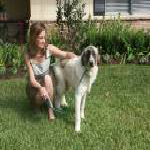

In [19]:
rand_img_path = rand_img_from_child_dirs(validation_data_dir)
rand_img = image.load_img(rand_img_path, target_size=(img_width, img_height))    
rand_dog_cat = 'dog' if 'validation/dogs' in rand_img_path else 'cat'

print(rand_img_path)
rand_img

In [20]:
x_test = image.img_to_array(rand_img)
x_test = x_test/255.0 # scaling as we have done in validation_datagen

In [21]:
print(f"Before: {x_test.shape}")
x_test = np.expand_dims(x_test, axis=0) # increase dimension so that can be fed into model
print(f"After: {x_test.shape}")

Before: (150, 150, 3)
After: (1, 150, 150, 3)


In [22]:
pred = np.asscalar(np.squeeze(test_model.predict_classes(x_test)))
prob = np.asscalar(np.squeeze(test_model.predict_proba(x_test))) # same as test_model.predict(x_test)

In [23]:
res = 'dog' if pred==1 else 'cat'
pct = round(prob*100,2)
if res is 'cat':
    pct = 100 - pct 

print('The model is ' + str(pct) + '% sure this is a ' + res)

The model is 99.64% sure this is a dog


## Evaluate on single image

model.evaluate() computes the loss based on the input you pass it, along with any other metrics that you requested in the metrics param when you compiled your model, e.g. accuracy in the MNIST example

In [24]:
Y_test = np.array([1]) if rand_dog_cat == 'dog' else np.array([0])
test_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
eval_scores = test_model.evaluate(x_test, Y_test, verbose=0)

In [25]:
test_model.metrics_names, eval_scores # since testing with 1 data, acc = 1 if correct, 0 if incorrect

(['loss', 'acc'], [0.0036428088787943125, 1.0])

## Predict on batch of test images

Unlike validation data, these are never seen or tested before

In [26]:
def predict(data_dir, model):
    preds = []
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = x/255.0
        x = np.expand_dims(x, axis=0)
        
        #prob = np.asscalar(np.squeeze(model.predict_proba(x)))
        pred = np.asscalar(np.squeeze(model.predict_classes(x)))
        preds.append(pred)
        
    return np.array(preds)

In [27]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

pred_dogs = predict(dog_test_dir, test_model)
pred_cats = predict(cat_test_dir, test_model)

In [28]:
# cat_acc = (1-pred_cats.mean())*100
# dog_acc = pred_dogs.mean()*100

cat_acc = len(pred_cats[pred_cats==0])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs==1])/len(pred_dogs) * 100
overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 77.80%
Dog Prediction Accuracy: 77.30%
Overall Accuract: 77.55%
